In [1]:
%load_ext autoreload
%autoreload
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pyImagingMSpec import inMemoryIMS
import sys
sys.path.insert(0, '/home/lomereiter/adp/pyImzML')
from pyimzml.ImzMLParser import ImzMLParser

file_in = "/home/lomereiter/metabolomics/20150804_ANB_spheroid_control2_215x190um_pos.imzML"
imzml = ImzMLParser(file_in)

In [4]:
import os
with open(os.path.expanduser("~/metabolomics/20150804_ANB_spheroid_control2_215x190um_pos.nmf")) as f:
    with np.load(f) as data:
        W = data['W']
        H = data['H']
        mz_axis = zip(*data['mz_axis'])[0]

<IPython.core.display.Javascript object>


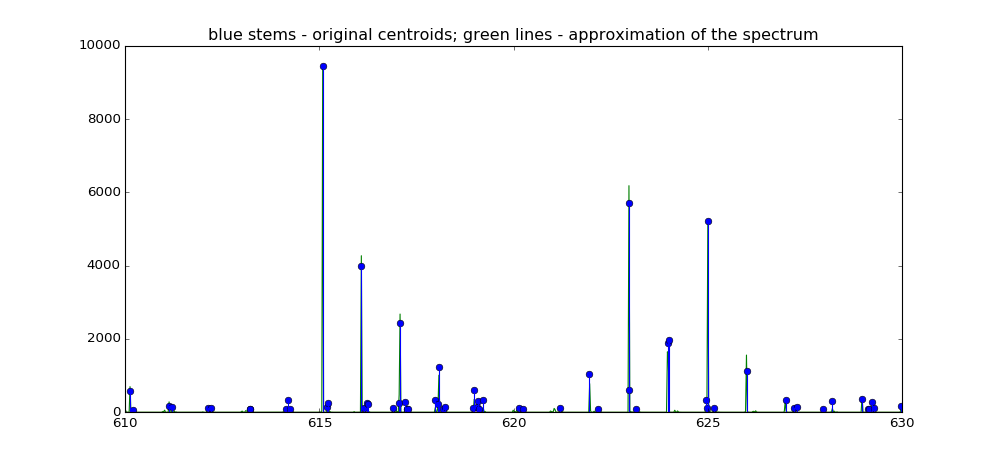

In [5]:
# visually check reconstruction quality for a spectrum

x = 50
y = 50
idx = [i for i, c in enumerate(imzml.coordinates) if c[:2] == (x, y)][0]
mzs, intensities = imzml.getspectrum(idx)

plt.figure(figsize=(20, 5))
plt.xlim((610, 630))
plt.ylim((0, 10000))
plt.plot(mz_axis, W.reshape((216, 191, -1))[x, y, :].dot(H), '-g')
plt.stem(mzs, intensities)
plt.title("blue stems - original centroids; green lines - approximation of the spectrum")

In [6]:
import os
import subprocess
pfg_executable_dir = os.path.expanduser("~/github/PFG")

import pandas as pd
import numpy as np

import urllib2, urllib
import json
from cpyMSpec import IsotopePattern

def _combine_results(dfs):  
    if len(dfs) == 0:
        return []
    
    df = pd.concat(dfs)
    df['abs_ppm'] = abs(df['ppm'])
    df = df.sort_values(by='abs_ppm')
    
    df = df[df['unsat'] >= 0]
    
    del df['abs_ppm']
    df.index = range(len(df))

    return df[['em', 'error', 'mf', 'ppm', 'unsat', 'adduct']]

def search_mz_candidates_pfg(mass, adducts, ppm_limit=5, charge=1):
    os.chdir(pfg_executable_dir)

    dfs = []
    for adduct in adducts:
        mass_ = mass - IsotopePattern(adduct).charged(charge).masses[0]
        cmd_line = ("OMP_NUM_THREADS=2 ./PFG -m {} -t {} " +\
                    "--C 0-100 --H 0-100 --N 0-10 --O 0-10 --S 0-5 --P 0-5 -r 'lewis'").format(mass_, ppm_limit)
        output = subprocess.check_output(cmd_line, shell=True)
        #print cmd_line, output
        results = open(os.path.join(pfg_executable_dir, "result.txt")).readlines()[1:]
        results = zip(*[s.split() for s in results])
        if not results:
            continue
        formula, _, mz, error, dbe = results
        
        #print result
        df = pd.DataFrame.from_dict({'mf': np.array(formula, dtype=str),
                                    'em': np.array(mz, dtype=float),
                                    'unsat': np.array(dbe, dtype=float).astype(int)
                                    })
   
        df['error'] = df['em'] - mass_
        df['ppm'] = df['error'] / mass_ * 1e6

        df['adduct'] = adduct
        dfs.append(df)
        
    return _combine_results(dfs)

In [7]:
from pyMSpec import centroid_detection
from pyMSpec.pyisocalc import pyisocalc

from cpyMSpec import IsotopePattern

class MoleculeAssigner(object):
    def __init__(self, target_database):
        
        # keep track of the already assigned sum formulas
        # so that if the same m/z appears in different components,
        # it (hopefully) gets assigned the same sum formula
        self._already_assigned = set()  
        
        # scoring the candidates for a given m/z incorporates our desire
        # to have some of the selected sum formulas from a predefined database;
        self._target_db = target_database
        
    def _normalize_sf(self, sf):
        return str(pyisocalc.parseSumFormula(sf))

    def _score_match(self, row, mzs_c, ints_c, ppm_t):
        # scoring candidates works in a very simple way at the moment:
        # 1) isotope pattern is generated
        # 2) number of isotopic peaks, that are present in the data, is counted
        # 3) the final score is #peaks + (2 if it's in CheBI) + (10 if we've seen the formula already)
        theor_spec = IsotopePattern("{}+{}".format(row.mf, row.adduct))\
                                        .charged(1).centroids(50000).trimmed(5)

        prev_intensity = None
        n = 0
        keep_list_all = np.ones_like(mzs_c, dtype=np.bool)
        for m, a in zip(theor_spec.masses, theor_spec.abundances):
            keep_list = 1e6 * np.abs(mzs_c - m) / m > ppm_t
            keep_list_all &= keep_list
            peak_list = np.where(np.logical_not(keep_list))[0]
            if len(peak_list) == 0:
                break
            intensity = ints_c[peak_list].sum()
            #print peak_list, intensity, a
            if prev_intensity and abs(intensity) > abs(prev_intensity):
                break
            prev_intensity = intensity
            n += 1
        normalized_mf = self._normalize_sf(row.mf)
        if normalized_mf in self._target_db:
            n += 2
        if normalized_mf in self._already_assigned:
            n += 10
        
        return n, keep_list_all

    def fit_spectrum(self, mzs_c, ints_c, ppm_t, max_peaks=50):
        order = np.argsort(np.abs(ints_c))
        mzs_c = np.asarray(mzs_c)[order]
        ints_c = np.asarray(ints_c)[order]

        n_peaks_initial = len(mzs_c)

        sf_list = []
        while len(mzs_c) > 0:
            mz = mzs_c[-1]
            v  = ints_c[-1]
            hits = search_mz_candidates_pfg(mz, ['H', 'Na', 'K'], ppm_limit=ppm_t)
            if len(hits) == 0:
                print 'no hits for {}'.format(mz)
                mzs_c = mzs_c[:-1]
                ints_c = ints_c[:-1]
                continue

            scores = [self._score_match(candidate, mzs_c, ints_c, ppm_t)[0] for candidate in hits.itertuples()]

            best_hit_idx = np.argmax(scores)
            best_hit = hits.iloc[best_hit_idx]

            keep_list = self._score_match(best_hit, mzs_c, ints_c, ppm_t)[1]
            if np.all(keep_list):
                # should not happen
                mzs_c = mzs_c[:-1]
                ints_c = ints_c[:-1]
                continue

            mzs_c = mzs_c[keep_list]
            ints_c = ints_c[keep_list]

            sf_list.append([v, best_hit])
            self._already_assigned.add(self._normalize_sf(best_hit['mf']))

            if len(sf_list) >= max_peaks:
                break

        stats = {}
        stats['n_peaks_explained'] = n_peaks_initial - len(mzs_c)
        stats['n_molecules'] = len(sf_list)
        return sf_list, stats
    
chebi = set()
n_invalid = 0
for line in open("/home/lomereiter/github/SM_distributed/chebi_organic2.csv"):
    try:
        sf_str = str(pyisocalc.parseSumFormula(line.split()[-1]))
        chebi.add(sf_str)
    except:
        n_invalid += 1
print len(chebi)

assigner = MoleculeAssigner(chebi)

spec_fit = []
chebi_percentage = []
for ii in range(H.shape[0]):
    print "coeff", ii
    coeff_spec = H[ii]
    
    # fit spectral component with 5 ppm tolerance for each of the top 50 peaks
    spec_fit.append(assigner.fit_spectrum(mz_axis, coeff_spec, 5, 50))
    
    sum_formulas = set([str(pyisocalc.parseSumFormula(x[1]['mf'])) for x in spec_fit[-1][0]])
    chebi_percentage.append(len(chebi & sum_formulas) / float(len(spec_fit[-1][0])))
    print "chebi percentage in component", ii+1, ":", chebi_percentage[-1]
print "median percentage of CheBI formulas:", np.median(chebi_percentage)

21506
coeff 0
no hits for 443.53749938
no hits for 444.544106831
no hits for 443.551653203
chebi percentage in component 1 : 0.26
coeff 1
chebi percentage in component 2 : 0.32
coeff 2
no hits for 326.380769168
chebi percentage in component 3 : 0.06
coeff 3
chebi percentage in component 4 : 0.22
coeff 4
chebi percentage in component 5 : 0.36
coeff 5
chebi percentage in component 6 : 0.26
coeff 6
chebi percentage in component 7 : 0.16
coeff 7
no hits for 443.53749938
chebi percentage in component 8 : 0.28
coeff 8
no hits for 326.380769168
chebi percentage in component 9 : 0.08
coeff 9
no hits for 326.380769168
chebi percentage in component 10 : 0.14
coeff 10
chebi percentage in component 11 : 0.06
coeff 11
chebi percentage in component 12 : 0.1
coeff 12
no hits for 298.343736421
no hits for 326.380769168
no hits for 299.353536832
no hits for 327.383706196
no hits for 328.382256498
no hits for 271.315852209
no hits for 300.35269788
no hits for 342.374969235
chebi percentage in component 

In [8]:
print imzml.imzmldict["max count of pixels x"], imzml.imzmldict["max count of pixels y"]

215 190


In [9]:
from collections import OrderedDict
layers = {}
layers['layers_list'] = OrderedDict()
for ii in range(len(spec_fit)):
    layers['layers_list'][ii] = {}
    layers['layers_list'][ii]['image'] = W[:, ii].reshape((216, 191))[1:, 1:]
    layers['layers_list'][ii]['sf_list'] = []
    for sf in spec_fit[ii][0]:
        sf_a = "{}+{}".format(sf[1]['mf'], sf[1]['adduct'])
        mult = [sf[0],]
        layers['layers_list'][ii]['sf_list'].append({"sf_a":sf_a, "mult":mult})

In [11]:
# save the layers for later analysis

import pickle

with open(os.path.expanduser("~/simulated_2016_05_03_2.layers.pkl"), "w+") as f:
    pickle.dump(layers, f)

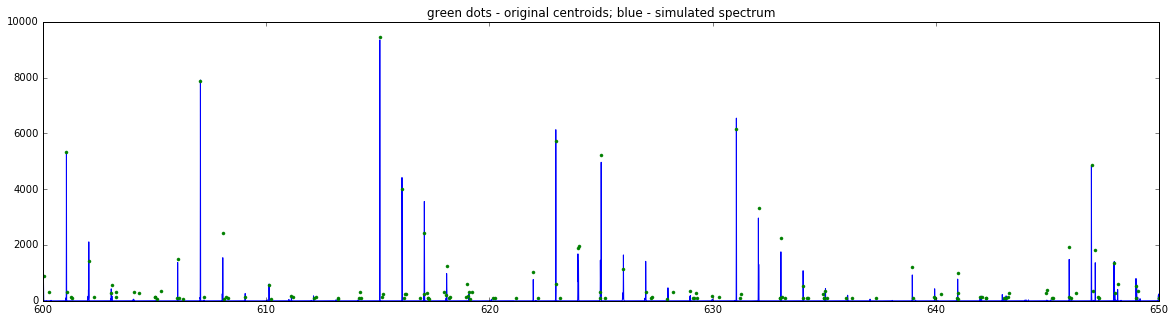

In [23]:
resolution_at_mz_200 = 140000

import cpyMSpec

isotope_patterns = {}

mz_axis = np.linspace(100, 1000, 1000000)

# precompute all isotope patterns and some auxilliary values
for i in layers['layers_list'].keys():
    layer = layers['layers_list'][i]
    isotope_patterns[i] = []
    for sf in layer['sf_list']:
        data = {}
        data['p'] = p = IsotopePattern(sf['sf_a']).charged(1)
        data['resolution'] = resolution_at_mz_200 * (200.0 / p.masses[0]) ** 0.5 # orbitrap
        data['l'] = np.searchsorted(mz_axis, min(p.masses) - 0.5, 'l')
        data['r'] = np.searchsorted(mz_axis, max(p.masses) + 1, 'r')
        data['fwhm'] = p.masses[0] / data['resolution']
        data['intensity'] = sf['mult'][0]
        isotope_patterns[i].append(data)

def simulate_spectrum(layers, x, y, centroids=True):
    result = np.zeros_like(mz_axis)
    for i in layers['layers_list'].keys():
        layer = layers['layers_list'][i]
        layer_intensity = layer['image'][x, y]
        for data in isotope_patterns[i]:
            intensity = data['intensity'] * layer_intensity
            
            # add a bit of noise by shifting m/z axis a little (FIXME: needs improvement)
            ppm = data['p'].masses[0] * 1e-6
            shift = np.random.normal(0, ppm * 0.1)
            
            l, r = data['l'], data['r']
            result[l:r] += intensity * data['p'].envelope(data['resolution'])(mz_axis[l:r] + shift)

    profile = (mz_axis, result)
    if centroids:
        p = cpyMSpec.centroidize(profile[0], profile[1])
        order = np.argsort(p.masses)
        masses = np.array(p.masses)[order]
        intensities = np.array(p.abundances)[order]
        
        # simulate detection limit (for real data estimated as 2e-3)
        
        high_ints = intensities > 1e-3
        masses = masses[high_ints]
        intensities = intensities[high_ints] * max(profile[1])
        # intensities *= max(profile[1])
        
        return masses, intensities                     
    else:
        return profile
    
%matplotlib inline
plt.figure(figsize=(20, 5))
plt.xlim((600, 650))
plt.ylim((0, 10000))

x = 50
y = 50
idx = [i for i, c in enumerate(imzml.coordinates) if c[:2] == (x, y)][0]

plt.plot(*simulate_spectrum(layers, x - 1, y - 1, False))

mzs, intensities = imzml.getspectrum(idx)
plt.plot(mzs, intensities, '.g')
plt.title("green dots - original centroids; blue - simulated spectrum")

# it is expected to have matching intensities for most principal isotopic peaks, but not the rest,
# simply because the score currently doesn't care about the intensities

In [14]:
from pyimzml_adp.ImzMLWriter import ImzMLWriter

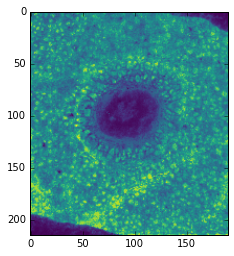

In [24]:
# for debugging purposes - generates an image for a small part of the axis:
# we don't want to waste N hours only to discover that the result is nonsensical

def simulate_image(layers, mz_min, mz_max):
    mz_axis = np.linspace(mz_min, mz_max, 100)
    img = np.zeros((215, 190, len(mz_axis)), dtype=float)

    for i in layers['layers_list'].keys():
        layer = layers['layers_list'][i]
        for data in isotope_patterns[i]:
            p = data['p']
            l = np.searchsorted(mz_axis, min(p.masses) - 0.5, 'l')
            r = np.searchsorted(mz_axis, max(p.masses) + 0.5, 'r')

            if l == r:
                continue
            
            resolution = data['resolution']
            intensity = data['intensity']
            fwhm = data['fwhm']
    
            for x in range(215):
                for y in range(190):
                    result = np.zeros_like(mz_axis, dtype=float)
                    layer_intensity = layer['image'][x, y]
                    
                    shift = np.random.normal(0, fwhm * 0.01)
                    
                    img[x, y, l:r] += intensity * layer_intensity * p.envelope(resolution)(mz_axis[l:r] + shift)
    return img

%matplotlib inline
img = simulate_image(layers, 332.3310, 332.3316)
plt.imshow(img.sum(axis=2), cmap='viridis')

In [25]:
print layers['layers_list'][0]['image'].shape

nx, ny = layers['layers_list'][0]['image'].shape

import joblib

with ImzMLWriter(os.path.expanduser("~/simulated_2016_05_03_2.imzML"), mz_dtype=np.float32) as w:
    step_x = 1
    step_y = 1
    for x in range(0, nx, step_x):
        spectra = joblib.Parallel(8)(joblib.delayed(simulate_spectrum)(layers, x, y) for y in range(0, ny, step_y))
        for y, spectrum in enumerate(spectra):
            mzs, intensities = spectrum
            w.addSpectrum(mzs, intensities, [x / step_x, y])
        print x


(215, 190)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
